In this notebook, we visualize four filtered outputs (a.k.a. activation maps) of a convolutional layer.

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Import the image

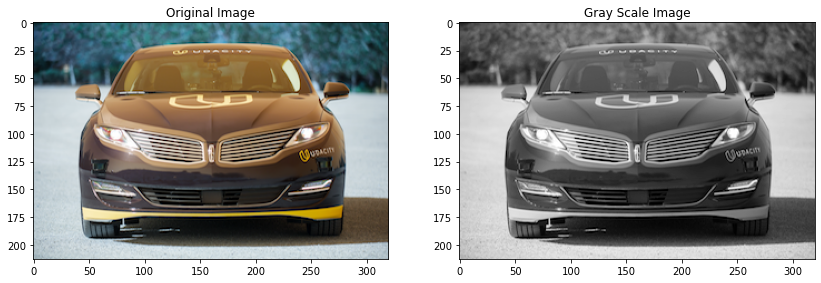

In [2]:
img_path = 'data/sdc.png'

# load color image 
bgr_img = cv2.imread(img_path)

#plot image
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Original Image')
plt.imshow(bgr_img)

# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Gray Scale Image')
plt.imshow(gray_img, cmap='gray')

plt.show()

### Define and visualize the filters

In [3]:
filter_vals = np.array([[-1, -1, 1, 1],
                      [-1, -1, 1, 1],
                      [-1, -1, 1, 1],
                      [-1, -1, 1, 1]])

print("Filter Shape:", filter_vals.shape)

Filter Shape: (4, 4)


In [4]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

filter1 = filter_vals
filter2 = -filter1
filter3 = filter1.T
filter4 = -filter1.T
filters = np.array([filter1, filter2, filter3, filter4])

print('Filter 1:\n', filter1)

Filter 1:
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]


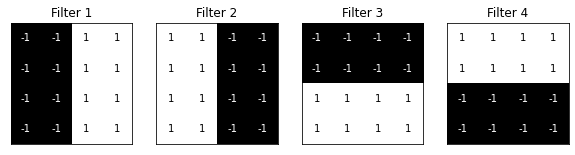

In [5]:
# visualizing four filters
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

### Convert numpy filters to torch tensor

In [6]:
filters.shape

(4, 4, 4)

In [7]:
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
weight

tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]])

# Define a convolutional layer

The various layers that make up any neural network are documented [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll start by defining a:
* Convolutional layer

Initializing a single convolutional layer so that it contains all the created filters. Note that we are not training this network; we are initializing the weights in a convolutional layer so that we can visualize what happens after a forward pass through this network!

In [8]:
k_height, k_width = weight.shape[2:]
conv = nn.Conv2d(1,4, kernel_size=(k_height, k_width), bias=False)
print(conv,'\n')
conv.weight

Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False) 



Parameter containing:
tensor([[[[-0.0974,  0.1716, -0.1472, -0.2464],
          [ 0.0677,  0.2276,  0.0977,  0.0588],
          [-0.1236, -0.1868,  0.1173,  0.0280],
          [ 0.0414, -0.0196,  0.1987, -0.1906]]],


        [[[-0.1447, -0.0751,  0.1862,  0.0020],
          [ 0.1157,  0.2428,  0.2050,  0.0039],
          [-0.0746, -0.0351, -0.0450,  0.1658],
          [-0.1279, -0.0379,  0.0960,  0.0308]]],


        [[[-0.2005, -0.1460, -0.0413,  0.2177],
          [-0.1597, -0.1537,  0.0763,  0.0010],
          [-0.2154,  0.1609,  0.0802,  0.1555],
          [ 0.1436,  0.0161,  0.2221, -0.0789]]],


        [[[-0.0519,  0.1460, -0.0011,  0.0531],
          [-0.1994,  0.0488,  0.1924,  0.1184],
          [-0.0191,  0.2295, -0.2163,  0.0883],
          [-0.0374, -0.2152,  0.2238,  0.1677]]]], requires_grad=True)

Update weights of conv layer with predefined filters

In [9]:
conv.weight = torch.nn.Parameter(weight)
conv.weight

Parameter containing:
tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]], requires_grad=True)

### Visualize the output of each filter

First, we'll define a helper function, `viz_layer` that takes in a specific layer and number of filters (optional argument), and displays the output of that layer once an image has been passed through.

In [10]:
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

Let's look at the output of a convolutional layer, before and after a ReLu activation function is applied.

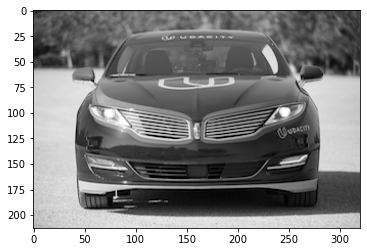

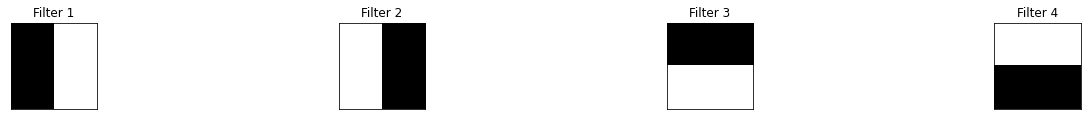

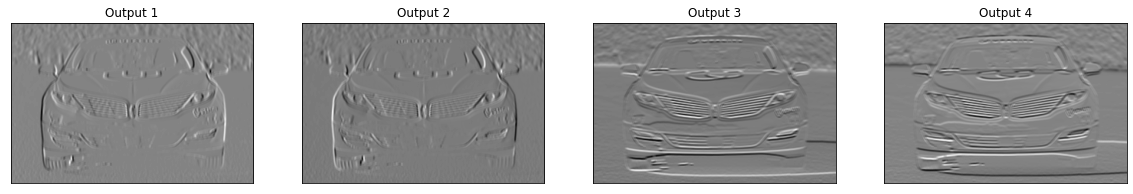

In [11]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# visualize the output of a conv layer
viz_layer(conv(gray_img_tensor))

#### ReLu activation

In this model, we've used an activation function that scales the output of the convolutional layer. We've chosen a ReLu function to do this, and this function simply turns all negative pixel values in 0's (black). See the equation pictured below for input pixel values, `x`. 
<img src='data/relu_ex.png' height=50% width=50% />

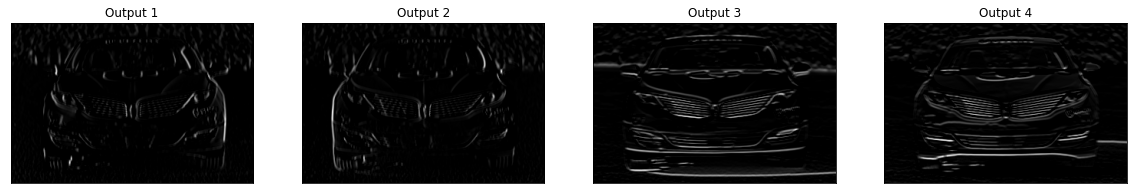

In [12]:
viz_layer(F.relu(conv(gray_img_tensor)))